In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.lines import Line2D
from celmech import Andoyer, AndoyerHamiltonian
from celmech.andoyer import get_Xstarres, get_Xstarunstable, get_Xstarnonres, get_Xsep
from sympy import init_printing
from matplotlib.patches import ConnectionPatch
from matplotlib import ticker

init_printing()


%matplotlib inline
plt.style.use('paper.mplstyle')

In [2]:
dfres = pd.read_csv('resPratios.csv', index_col=0)
dfres.tail()

,runstring,instability_time,shadow_instability_time,Stable,Pratio21,Pratio32,beta12,beta23
89700,9045377.bin,6.990387e+05,8.267916e+05,False,2.146925,1.125825,22.762855,4.500139
89701,9045378.bin,3.075749e+08,6.576003e+08,False,1.399777,1.435985,15.316273,14.379617
89702,9045380.bin,1.193822e+07,3.363291e+07,False,1.204069,1.597688,4.036607,21.136880
89703,9045382.bin,2.064407e+08,4.316851e+07,False,1.330065,1.647766,7.294859,15.323072
89704,9045383.bin,2.266066e+04,2.228425e+04,False,1.285910,1.710886,8.965751,20.618763


In [6]:
(dfres['instability_time'] > 9.95e8).sum()

2607

In [5]:
(dfres['Stable'] == True).sum()

2599

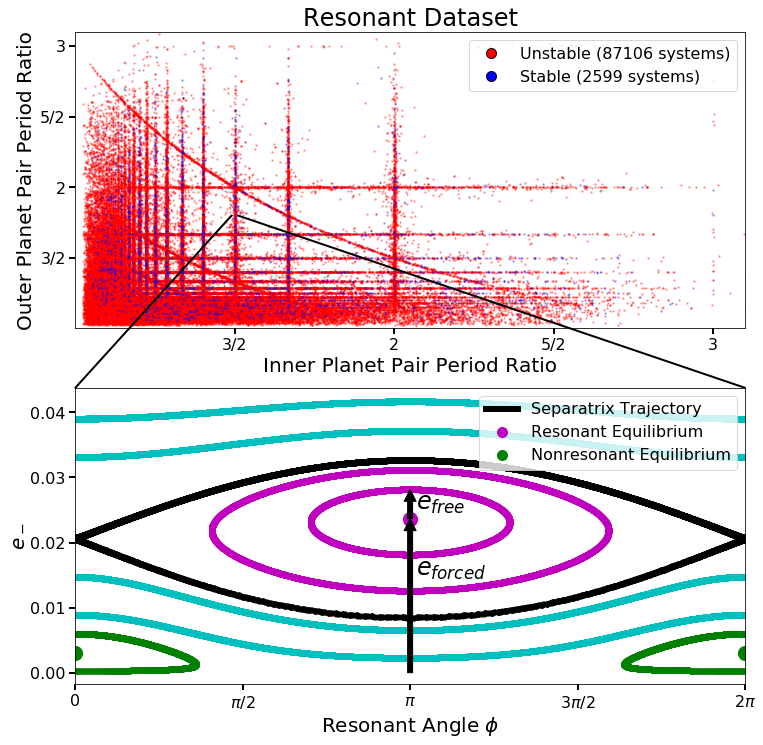

In [3]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(nrows=2, ncols=1, figure=fig)
#gs.update(wspace=0.0)

stable = dfres['instability_time'] > 9.99e8
ax2 = plt.subplot(gs[0])
ax2.set_rasterization_zorder(1)
ax2.scatter(dfres['Pratio21'][~stable], dfres['Pratio32'][~stable], c = 'r', s=2, alpha=0.3, zorder=0)
ax2.scatter(dfres['Pratio21'][stable], dfres['Pratio32'][stable], c = 'b', s=2, alpha=0.3, zorder=0)

ax2.set_xlim([1,3.1])
ax2.set_ylim([1,3.1])
ax2.set_ylabel('Outer Planet Pair Period Ratio')
ax2.set_xlabel('Inner Planet Pair Period Ratio')
ax2.set_title('Resonant Dataset')

ax2.set_xticks([1.5,2.,2.5, 3.])
ax2.set_xticklabels(['3/2', '2', '5/2', '3'])
ax2.set_yticks([1.5,2.,2.5, 3.])
ax2.set_yticklabels(['3/2', '2', '5/2', '3'])


Nstable = stable.sum()
Nunstable = (~stable).sum()
legend_elements = [Line2D([0], [0], marker='o', lw=0, c='k', markerfacecolor='r', label='Unstable ({0} systems)'.format(Nunstable), markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='k', label='Stable ({0} systems)'.format(Nstable), markerfacecolor='b', markersize=10)]
ax2.legend(handles=legend_elements, loc='upper right')

ax3 = plt.subplot(gs[1])

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

def Phiprime(B):
    return 8.*B/3.

def B(Phiprime):
    return 3.*Phiprime/8.

j=3
k=1

Phiprime = 2.
andvars = Andoyer(j=j, k=k, X=0., Y=0., B=B(Phiprime))
Xstarres = get_Xstarres(k, Phiprime)
Xstarnonres = get_Xstarnonres(k, Phiprime)
Xstarunstable = get_Xstarunstable(k, Phiprime)
Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
Xbanana1 = Xstarres + (Xsep_outer-Xstarres)/2.
Xbanana2 = Xstarres + 5*(Xsep_outer-Xstarres)/6.
XIC = Xstarnonres + (Xstarunstable-Xstarnonres)/6.
Xcircle1 = Xstarnonres + (Xstarunstable-Xstarnonres)/3.
Xcircle2 = Xstarnonres + 2*(Xstarunstable-Xstarnonres)/3.
Xouter1 = Xsep_outer + (Xsep_outer-Xstarres)/2
Xouter2 = Xsep_outer + (Xsep_outer-Xstarres)

Zstarres = andvars.Zstar
Zstarunstable = andvars.Zstar_unstable
Zstarnonres = andvars.Zstar_nonres
Zsep_inner = andvars.Zsep_inner
Zsep_outer = andvars.Zsep_outer
Xs = [Xbanana1, Xbanana2, XIC, Xcircle1, Xcircle2, Xsep_outer, Xsep_inner, Xouter1, Xouter2]
colors = ['m', 'm', 'g', 'c', 'c', 'k', 'k', 'c', 'c']

ax3.set_rasterization_zorder(1)
for X, color in zip(Xs, colors):
    andvars = Andoyer(j=j, k=k, X=X, Y=0., B=B(Phiprime))
    H = AndoyerHamiltonian(andvars)
    tmax=100*andvars.params['tau']
    Nout = 10000
    times = np.linspace(0, tmax, Nout)

    Z, phi = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        H.integrate(time)
        Z[i] = H.state.Z
        phi[i] = H.state.phi
    ax3.plot(phi, Z, '.', c=color, zorder=0)
    
ax3.scatter(np.pi, Zstarres, c='m', marker='o', s=200)
ax3.scatter(0, Zstarnonres, c='g', marker='o', s=200)
ax3.scatter(2*np.pi, Zstarnonres, c='g', marker='o', s=200)
ax3.annotate("", xy=(np.pi, Zstarres), xytext=(np.pi, 0), arrowprops=dict(width=5, facecolor='k'))
ax3.annotate("", xy=(np.pi, Zstarres + (Zsep_outer-Zstarres)/2), xytext=(np.pi, Zstarres), arrowprops=dict(width=5, facecolor='k'))
ax3.text(3.2, 0.015, r"$e_{forced}$", fontsize=24)
ax3.text(3.2, 0.025, r"$e_{free}$", fontsize=24)
ax3.set_xticks([np.pi/2*i for i in range(5)])
ax3.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax3.set_xlabel('Resonant Angle $\phi$')
ax3.set_ylabel('$e_-$')
ax3.set_xlim([0,2*np.pi])
legend_elements = [Line2D([0], [0], lw=6, c='k', label='Separatrix Trajectory'),
                   Line2D([0], [0], marker='o', lw=0, c='m', markerfacecolor='m', label='Resonant Equilibrium', markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='g', label='Nonresonant Equilibrium', markerfacecolor='g', markersize=10)]
ax3.legend(handles=legend_elements, loc='upper right')

ax2.add_artist(ConnectionPatch(xyA=(1.49, 1.8), xyB=(0, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax2, axesB=ax3, color="k", linewidth=2))
ax2.add_artist(ConnectionPatch(xyA=(1.51, 1.8), xyB=(1, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax2, axesB=ax3, color="k", linewidth=2))


fig.savefig('resdataset.pdf', bbox_inches='tight', rasterized=True, dpi=300)

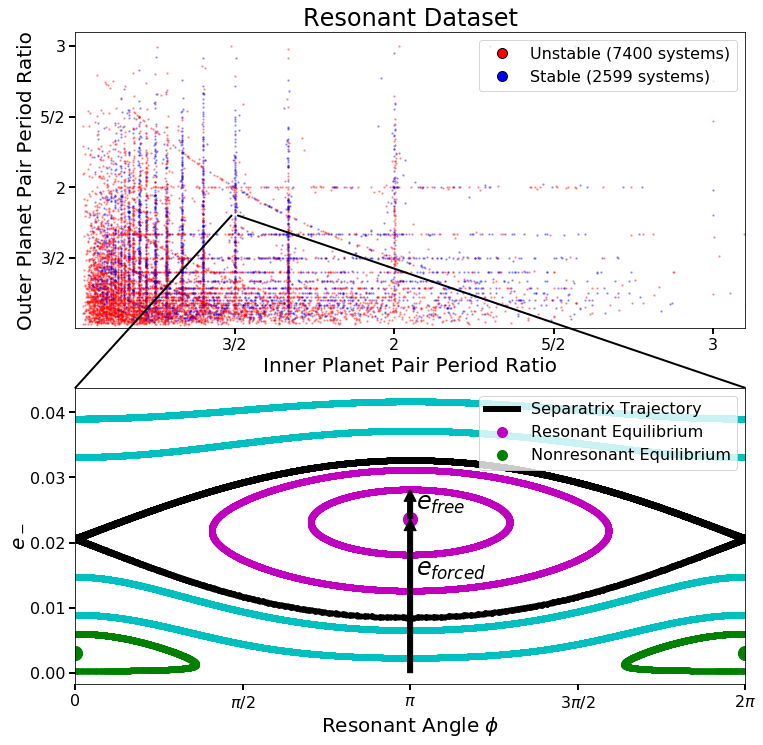

In [9]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(nrows=2, ncols=1, figure=fig)
#gs.update(wspace=0.0)

stable = dfres['instability_time'] > 9.99e8
ax2 = plt.subplot(gs[0])
ax2.set_rasterization_zorder(1)
ax2.scatter(dfres['Pratio21'][~stable], dfres['Pratio32'][~stable], c = 'r', s=2, alpha=0.3, zorder=0)
ax2.scatter(dfres['Pratio21'][stable], dfres['Pratio32'][stable], c = 'b', s=2, alpha=0.3, zorder=0)

ax2.set_xlim([1,3.1])
ax2.set_ylim([1,3.1])
ax2.set_ylabel('Outer Planet Pair Period Ratio')
ax2.set_xlabel('Inner Planet Pair Period Ratio')
ax2.set_title('Resonant Dataset')

ax2.set_xticks([1.5,2.,2.5, 3.])
ax2.set_xticklabels(['3/2', '2', '5/2', '3'])
ax2.set_yticks([1.5,2.,2.5, 3.])
ax2.set_yticklabels(['3/2', '2', '5/2', '3'])


Nstable = stable.sum()
Nunstable = (~stable).sum()
legend_elements = [Line2D([0], [0], marker='o', lw=0, c='k', markerfacecolor='r', label='Unstable ({0} systems)'.format(Nunstable), markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='k', label='Stable ({0} systems)'.format(Nstable), markerfacecolor='b', markersize=10)]
ax2.legend(handles=legend_elements, loc='upper right')

ax3 = plt.subplot(gs[1])

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

def Phiprime(B):
    return 8.*B/3.

def B(Phiprime):
    return 3.*Phiprime/8.

j=3
k=1

Phiprime = 2.
andvars = Andoyer(j=j, k=k, X=0., Y=0., B=B(Phiprime))
Xstarres = get_Xstarres(k, Phiprime)
Xstarnonres = get_Xstarnonres(k, Phiprime)
Xstarunstable = get_Xstarunstable(k, Phiprime)
Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
Xbanana1 = Xstarres + (Xsep_outer-Xstarres)/2.
Xbanana2 = Xstarres + 5*(Xsep_outer-Xstarres)/6.
XIC = Xstarnonres + (Xstarunstable-Xstarnonres)/6.
Xcircle1 = Xstarnonres + (Xstarunstable-Xstarnonres)/3.
Xcircle2 = Xstarnonres + 2*(Xstarunstable-Xstarnonres)/3.
Xouter1 = Xsep_outer + (Xsep_outer-Xstarres)/2
Xouter2 = Xsep_outer + (Xsep_outer-Xstarres)

Zstarres = andvars.Zstar
Zstarunstable = andvars.Zstar_unstable
Zstarnonres = andvars.Zstar_nonres
Zsep_inner = andvars.Zsep_inner
Zsep_outer = andvars.Zsep_outer
Xs = [Xbanana1, Xbanana2, XIC, Xcircle1, Xcircle2, Xsep_outer, Xsep_inner, Xouter1, Xouter2]
colors = ['m', 'm', 'g', 'c', 'c', 'k', 'k', 'c', 'c']

ax3.set_rasterization_zorder(1)
for X, color in zip(Xs, colors):
    andvars = Andoyer(j=j, k=k, X=X, Y=0., B=B(Phiprime))
    H = AndoyerHamiltonian(andvars)
    tmax=100*andvars.params['tau']
    Nout = 10000
    times = np.linspace(0, tmax, Nout)

    Z, phi = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        H.integrate(time)
        Z[i] = H.state.Z
        phi[i] = H.state.phi
    ax3.plot(phi, Z, '.', c=color, zorder=0)
    
ax3.scatter(np.pi, Zstarres, c='m', marker='o', s=200)
ax3.scatter(0, Zstarnonres, c='g', marker='o', s=200)
ax3.scatter(2*np.pi, Zstarnonres, c='g', marker='o', s=200)
ax3.annotate("", xy=(np.pi, Zstarres), xytext=(np.pi, 0), arrowprops=dict(width=5, facecolor='k'))
ax3.annotate("", xy=(np.pi, Zstarres + (Zsep_outer-Zstarres)/2), xytext=(np.pi, Zstarres), arrowprops=dict(width=5, facecolor='k'))
ax3.text(3.2, 0.015, r"$e_{forced}$", fontsize=24)
ax3.text(3.2, 0.025, r"$e_{free}$", fontsize=24)
ax3.set_xticks([np.pi/2*i for i in range(5)])
ax3.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax3.set_xlabel('Resonant Angle $\phi$')
ax3.set_ylabel('$e_-$')
ax3.set_xlim([0,2*np.pi])
legend_elements = [Line2D([0], [0], lw=6, c='k', label='Separatrix Trajectory'),
                   Line2D([0], [0], marker='o', lw=0, c='m', markerfacecolor='m', label='Resonant Equilibrium', markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='g', label='Nonresonant Equilibrium', markerfacecolor='g', markersize=10)]
ax3.legend(handles=legend_elements, loc='upper right')

ax2.add_artist(ConnectionPatch(xyA=(1.49, 1.8), xyB=(0, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax2, axesB=ax3, color="k", linewidth=2))
ax2.add_artist(ConnectionPatch(xyA=(1.51, 1.8), xyB=(1, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax2, axesB=ax3, color="k", linewidth=2))


fig.savefig('resdataset.pdf', bbox_inches='tight', rasterized=True, dpi=300)